In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import json
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MultiLabelBinarizer
import time
from scipy import stats
from scipy.spatial import distance
#import chime
#import ijson

from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import PredefinedKFold, GridSearchCV

import psycopg2
from pymongo import MongoClient

import scipy

import gc

from funk_svd import SVD 
import tensorflow as tf

import os
from IPython.display import Image, HTML
pd.set_option('display.max_colwidth', -1)


from scipy.special import gammaln

from HBayes.data_process import obtain_data, sample_data_out
from HBayes.vm import VBms
from HBayes.utilfun import *

C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_6008\2252375818.py:40: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Data Load

In [2]:
client = MongoClient(host='10.10.224.28',
                     port=27017,
                     username='vida',
                     password='qwer123$')

db_datamart = client['datamart']

In [3]:
#collection = db_datamart['dm_orderseries']
#temp = collection.find()
#dataframe_orderseries = DataFrame(temp)

In [4]:
dataframe_orderseries = pd.read_csv('../데이터 추출/BD/orderseries/BD_주문시계열_20220901_20220217.csv')

C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_6008\1438092967.py:1: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe_orderseries = pd.read_csv('../데이터 추출/BD/orderseries/BD_주문시계열_20220901_20220217.csv')


In [5]:
#collection = db_datamart['dm_merchandise']
#temp = collection.find({'productId': {'$in' : list(dataframe_orderseries['productId'])}})
#dataframe_merchandise = DataFrame(temp)

In [6]:
productid = tuple(dataframe_orderseries.loc[dataframe_orderseries['productId'].apply(lambda x : len(str(x).split('_')) <= 1),
                          'productId'].astype(int).unique())

In [7]:
collection = db_datamart['dm_buyer']
temp = collection.find()
dataframe_buyer = DataFrame(temp)

In [8]:
brand_favorite = {"SQL" : "select tfb.\"brand\"" + (
                  ", tfb.\"buyer\"") + (
                  ", tfb.\"created_at\" at time zone 'Asia/Seoul'") + (
                  " from tb_favorite_brand tfb"),
            "columns" : ['brandId','buyerId','yeramon']}

In [9]:
collection = db_datamart['dm_seller']
temp = collection.find()
dataframe_seller = DataFrame(temp)

In [10]:
brand_favorite = {"SQL" : "select tfb.\"brand\"" + (
                  ", tfb.\"buyer\"") + (
                  ", tfb.\"created_at\" at time zone 'Asia/Seoul'") + (
                  " from tb_favorite_brand tfb"),
            "columns" : ['brandId','buyerId','yeramon']}

In [11]:
products = {"SQL" : "select id" + (
                  ", \"name\"->'ko'") + (
                  ", \"appImages\"") + (
                  ", \"data\"") + (
                  ", \"brand\"") + (
                  ", \"createdAt\" at time zone 'Asia/Seoul'") + (
                  " from products where ") + (
                  f"id in {productid}"),
            "columns" : ['productId','name','images','SKUdata','brand','createdAt']}

In [12]:

wishes = {"SQL" : "select wis.\"brandId\"" + (
                  ", \"userId\"") + (
                  ", \"productId\"") + (
                  ", \"createdAt\"") + (
                  " from wishes wis where ") + (
                  "wis.status = 100 "),
            "columns" : ['brandId','buyerId','productId', 'createdAt']}


In [13]:
conn = psycopg2.connect("host=restore.cy1gcw3mvrbf.ap-northeast-2.rds.amazonaws.com port=5432 user=linkshops password=$dpdlvmflf4 dbname=linkshops")

curs = conn.cursor()

In [14]:
curs.execute(products['SQL'])
dataframe_merchandise = DataFrame(curs)
dataframe_merchandise.columns = products['columns']

In [15]:
curs.execute(wishes['SQL'])
dataframe_wishes = DataFrame(curs)
dataframe_wishes.columns = wishes['columns']

In [16]:
curs.execute(brand_favorite['SQL'])
dataframe_favorite = DataFrame(curs)
dataframe_favorite.columns = brand_favorite['columns']
conn.close()

In [17]:
merchandise = dataframe_merchandise.copy()
favorite = dataframe_favorite.copy()

In [18]:
def type_extractor(x, types, recursive=None):
    try:
        if recursive is None:
            return x[0][types]
        else:
            return type_extractor([x[0][types]],
                                  types=recursive)
    except:
        return 'NaN'

In [19]:
def min_max_scailing(x, except_col):
    if except_col is not None:
        max_value = np.max(x.drop([except_col]))
        min_value = np.min(x.drop([except_col]))
        temp = (x.drop([except_col]) - min_value) / (max_value - min_value)
        temp = DataFrame(temp).T
        return pd.concat([DataFrame(x[[except_col]]).T, temp], axis = 1)
    else :
        max_value = np.max(x)
        min_value = np.min(x)
        temp = (x - min_value) / (max_value - min_value)
        #temp = DataFrame(temp).T
        return temp

In [ ]:
'''
merchandise['category'] = \
merchandise['SKUdata'].apply(lambda x : type_extractor(
                                                    type_extractor([x], 
                                                                   'data', 
                                                                   recursive='categoryPath'),
                                                    'en'))
'''
merchandise['category'] = \
merchandise['SKUdata'].apply(lambda x : type_extractor(type_extractor([x], 'categoryPath'), 'en'))


merchandise['brandId'] = merchandise['brand'].apply(lambda x : type_extractor([x], 'id'))

merchandise['cat_0'] = merchandise['category'].apply(lambda x : x[0])
merchandise['cat_1'] = merchandise['category'].apply(lambda x : x[1] if len(x) > 2 else None)
merchandise['cat_2'] = merchandise['category'].apply(lambda x : x[2] if len(x) > 2 else None)

merchandise['images'] = \
merchandise['images'].apply(lambda x : type_extractor(type_extractor([x], 
                                                                      'default'),
                                                      'url'))
    
#merchandise['prodName'] = merchandise['SKUdata'].apply(lambda x : type_extractor([x], 'name', recursive = 'ko'))

merchandise = merchandise.rename({'name' : 'prodName'}, axis = 1)
merchandise = merchandise.astype({'productId' : str})

merchandise_reduced = merchandise[['productId','images','prodName','cat_0','cat_1','cat_2']]

merchandise_reduced = merchandise_reduced.drop_duplicates()

orderseries_merchandise = \
pd.merge(dataframe_orderseries,
         merchandise_reduced,
         on = 'productId',
        how = 'inner')

In [22]:
'''
merchandise['category'] = \
merchandise['SKUdata'].apply(lambda x : type_extractor(
                                                    type_extractor([x], 
                                                                   'data', 
                                                                   recursive='categoryPath'),
                                                    'en'))
'''
merchandise['category'] = \
merchandise['SKUdata'].apply(lambda x : type_extractor(type_extractor([x], 'categoryPath'), 'en'))


merchandise['brandId'] = merchandise['brand'].apply(lambda x : type_extractor([x], 'id'))

merchandise['cat_0'] = merchandise['category'].apply(lambda x : x[0])
merchandise['cat_1'] = merchandise['category'].apply(lambda x : x[1] if len(x) > 2 else None)
merchandise['cat_2'] = merchandise['category'].apply(lambda x : x[2] if len(x) > 2 else None)

merchandise['images'] = \
merchandise['images'].apply(lambda x : type_extractor(type_extractor([x], 
                                                                      'default'),
                                                      'url'))
    
#merchandise['prodName'] = merchandise['SKUdata'].apply(lambda x : type_extractor([x], 'name', recursive = 'ko'))

merchandise = merchandise.rename({'name' : 'prodName'}, axis = 1)
merchandise = merchandise.astype({'productId' : str})

merchandise_reduced = merchandise[['productId','images','prodName','cat_0','cat_1','cat_2']]

merchandise_reduced = merchandise_reduced.drop_duplicates()

orderseries_merchandise = \
pd.merge(dataframe_orderseries,
         merchandise_reduced,
         on = 'productId',
        how = 'inner')

del merchandise, merchandise_reduced

gc.collect()

500

In [24]:
wishes = dataframe_wishes.copy()

wishes_reduced = \
pd.merge(wishes,
         orderseries_merchandise[['productId']].drop_duplicates().astype('int'))


wishes_reduced = wishes_reduced[['buyerId','productId']].drop_duplicates()

wishes_reduced['values'] = 1

buyerId_dict = {j : i for i,j in enumerate(wishes_reduced['buyerId'].unique())}
productId_dict = {j : i for i,j in enumerate(wishes_reduced['productId'].unique())}

productId_set = set(productId_dict.keys())

wishes_reduced['buyerId'] = [buyerId_dict[i] for i in wishes_reduced['buyerId']]
wishes_reduced['productId'] = [productId_dict[i] for i in wishes_reduced['productId']]

row = np.array(wishes_reduced['productId'])
col = np.array(wishes_reduced['buyerId'])
values = np.array(wishes_reduced['values'])



In [25]:
wishes_coo = scipy.sparse.coo_matrix((values, (row, col)))

wishes_coo = wishes_coo.astype('float64')

wishes_coo = wishes_coo.toarray()

del row,col,values,wishes_reduced,wishes

# DataEDA

In [30]:
a = orderseries_merchandise.groupby(['buyerId'])[['productId']].value_counts().reset_index()

In [31]:
favorite_pivot = a.pivot_table(index = ['buyerId'],
                               columns = 'productId',
                               values = 0)

In [32]:
favorite_pivot = favorite_pivot.reset_index()

favorite_pivot = favorite_pivot.fillna(0)

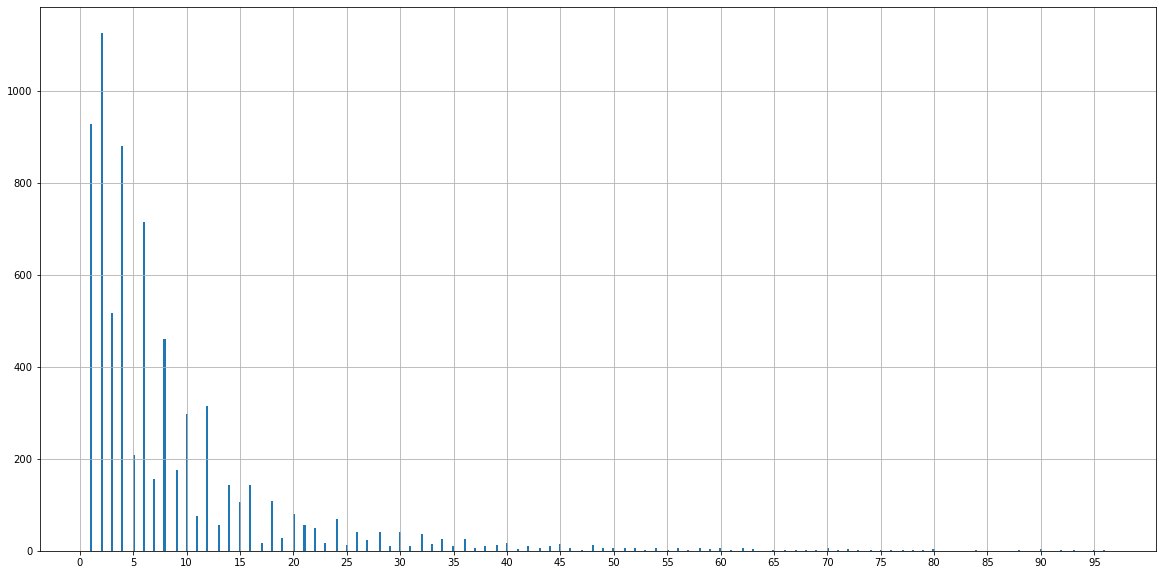

In [24]:
plt.figure(figsize = (20,10))
favorite_pivot.iloc[:,1:].apply(lambda x : max(x) if max(x) < 100 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,100,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = {\max{X_{i}}} $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$

최댓값만 고려하였을땐 위에서 선언한 목적에서 다음의 사안을 위반한다

- 집중도 미반영
- 손실 갯수 최소화 : 계급값 2 이하를 제외한다해도 약 800개의 샘플이 손실된다.

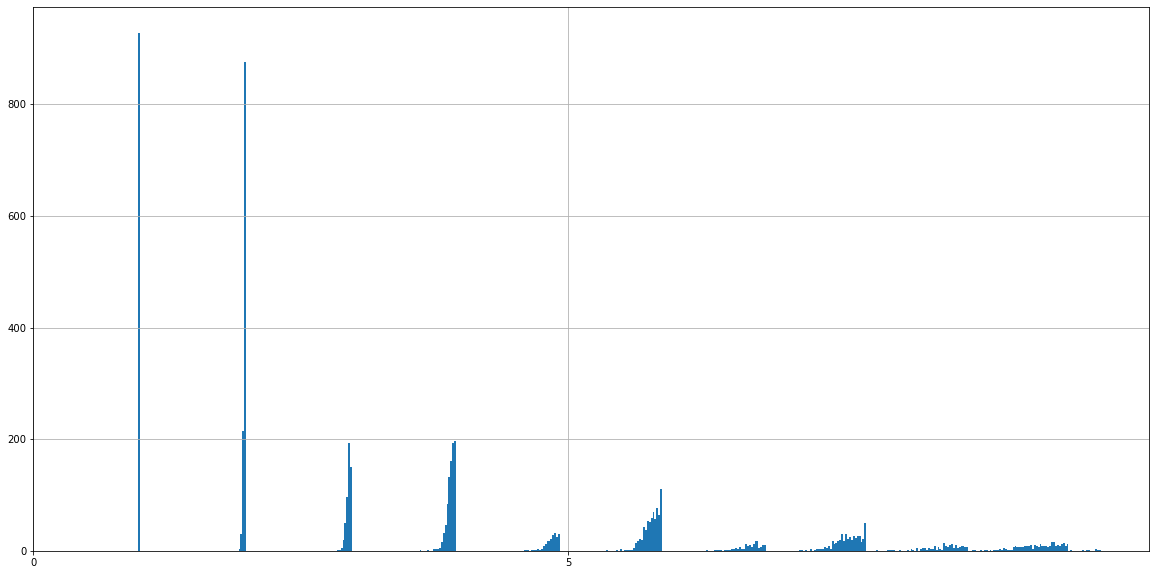

In [25]:
plt.figure(figsize = (20,10))
favorite_pivot.iloc[:,1:].apply(lambda x : max(x) / (np.std(x) + 1) if max(x) / (np.std(x) + 1) < 10 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,10,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = {\max{X_{i}} \over std(X_{i}) + 1} $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$
$$ std 는 표준편차 $$

심플한 착안으로, 

- 해당 바이어의 구매 이력이 고르게 퍼져있을수록(=표준편차가 작을수록) 값이 커지고, 특정 값에 몰려있을수록(=표준 편차가 클수록) 값이 작아진다

- 여기에 해당 바이어 구매 이력의 최댓값(max X_i)를 가져와서 최댓값이 클수록 값이 커진다.

최댓값만 고려하였을땐 위에서 선언한 목적에서 다음의 사안을 위반한다

- 손실 갯수 최소화 : 대부분의 값이 0 ~ 5 사이에 몰려있어 너무 많은 샘플을 손실할 우려가 존재한다

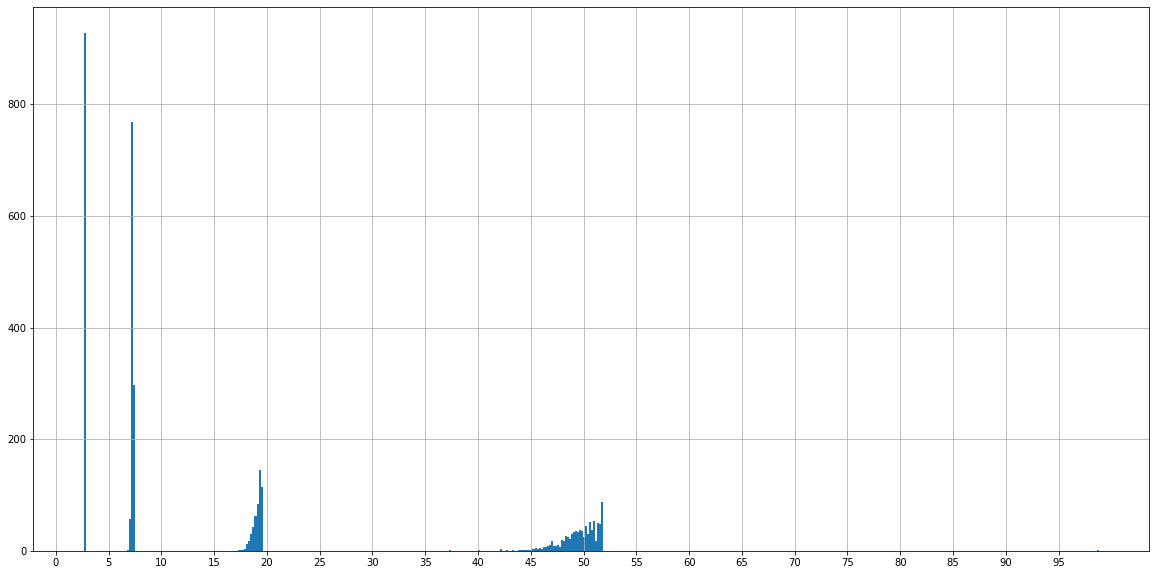

In [26]:
plt.figure(figsize = (20,10))
favorite_pivot.iloc[:,1:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)) 
                      if np.exp(max(x) / (np.std(x) + 1)) < 100 else None, axis = 1).hist(bins = 500)
plt.xticks(range(0,100,5))
plt.show()

다음의 식으로 변환한 값의 히스토그램이다

$$ score = exp({\max{X_{i}} \over std(X_{i}) + 1}) $$

$$단$$
$$ X_{i} i번째 바이어의 구매 이력(행) $$
$$ std 는 표준편차 $$

바로 위 변환 수식을 지수변환하여 저점수 / 고점수간 계급값 차이를 극대화한다

In [33]:
favorite_pivot['values'] = favorite_pivot.iloc[:,1:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)), axis = 1)

In [28]:
favorite_pivot['values'].describe()

count    7.240000e+03
mean     4.594342e+58
std      3.909243e+60
min      2.671996e+00
25%      7.289124e+00
50%      1.350488e+02
75%      1.518570e+04
max      3.326304e+62
Name: values, dtype: float64

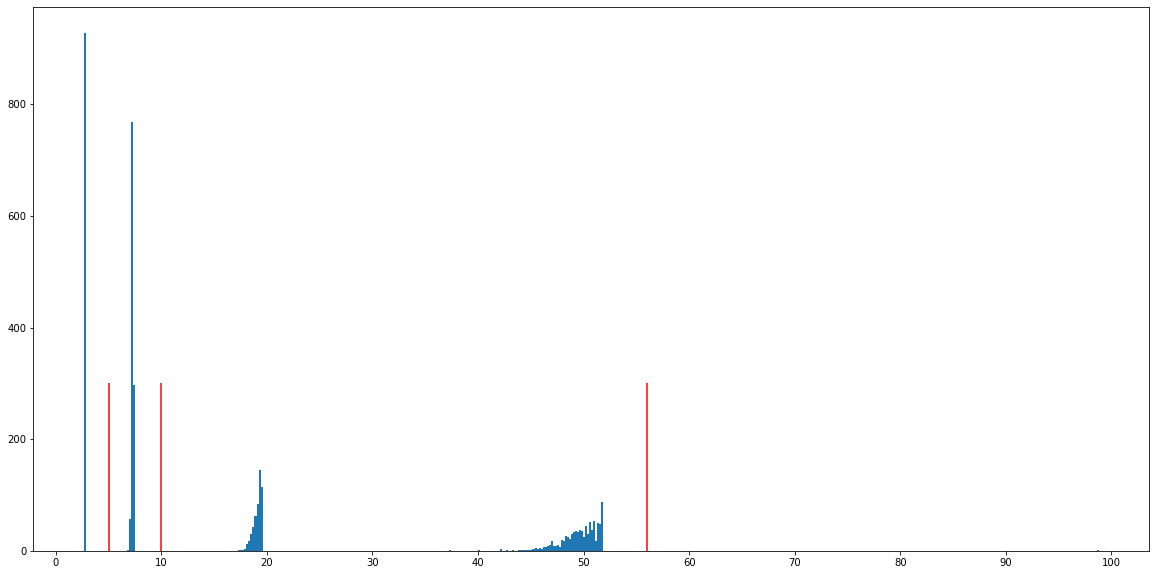

In [29]:
plt.figure(figsize = (20,10))
plt.hist(favorite_pivot.loc[favorite_pivot['values'] < 100, 'values'], bins = 500)
plt.xticks(range(0, 220, 10))
plt.vlines([5,10,56], ymin = 0, ymax = 300, color = 'red')
plt.show()

In [30]:
(favorite_pivot['values'] >= 10).value_counts()

True     5187
False    2053
Name: values, dtype: int64

In [34]:
favorite_pivot = favorite_pivot[favorite_pivot['values'] >= 10]
favorite_pivot = favorite_pivot.drop(['values'], axis = 1)

In [35]:
favorite_pivot_t = favorite_pivot.T

In [36]:
favorite_pivot_t['values'] = favorite_pivot_t.iloc[1:,:].apply(lambda x : np.exp(max(x) / (np.std(x) + 1)), axis = 1)

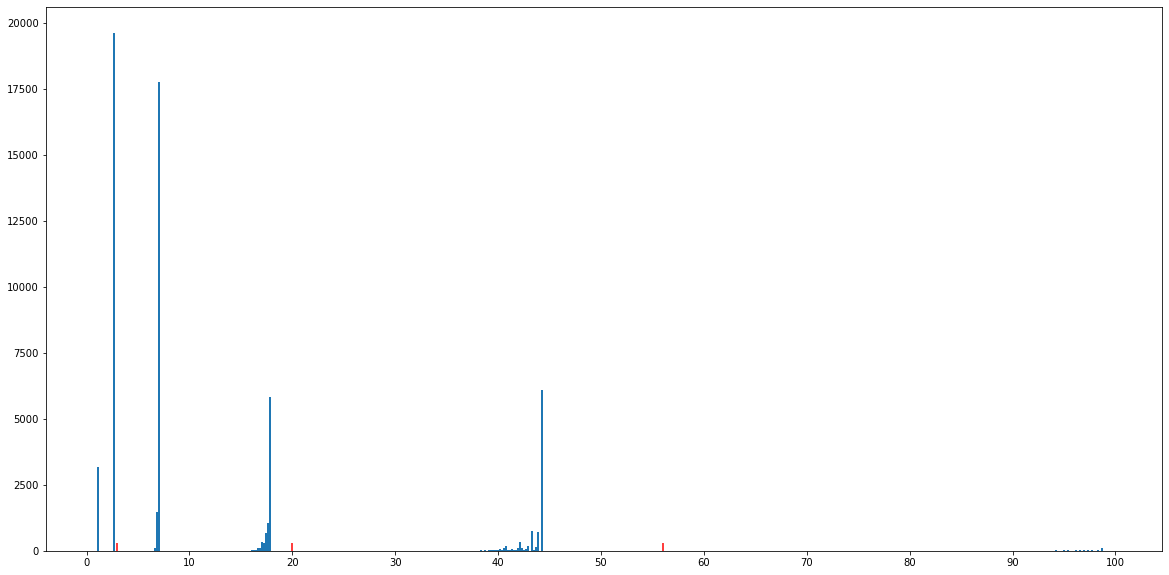

In [34]:
plt.figure(figsize = (20,10))
plt.hist(favorite_pivot_t.loc[favorite_pivot_t['values'] < 100, 'values'], bins = 500)
plt.xticks(range(0, 220, 10))
plt.vlines([3,20,56], ymin = 0, ymax = 300, color = 'red')
plt.show()

In [37]:
(favorite_pivot_t['values'] >= 5).value_counts()

True     62305
False    22818
Name: values, dtype: int64

In [37]:
favorite_pivot_t = favorite_pivot_t[favorite_pivot_t['values'] > 5]

In [38]:
favorite_pivot = pd.concat([favorite_pivot['buyerId'],
            favorite_pivot_t.T.drop('values')],
         axis = 1)

<AxesSubplot:>

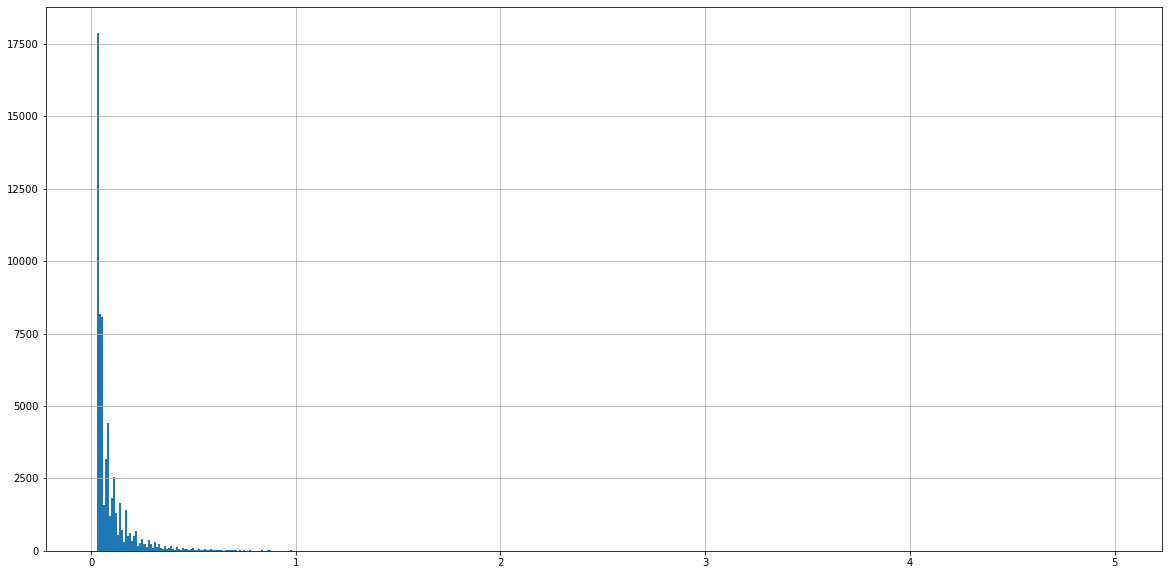

In [40]:
plt.figure(figsize = (20,10))
favorite_pivot.iloc[:,1:].apply(lambda x : np.std(x)).hist(bins = 500)

In [41]:
a = (favorite_pivot.iloc[:,1:] == 0).apply(lambda x : x.value_counts())

In [42]:
1 - np.sum(a.loc[False]) / np.sum(a.loc[True])

0.9996539542723762

In [39]:
favorite_pivot_scailing = favorite_pivot.apply(lambda x : min_max_scailing(x, 'buyerId'), axis = 1)

favorite_pivot_scailing = pd.concat(favorite_pivot_scailing.values)

In [40]:
favorite_pivot_scailing_melt = favorite_pivot_scailing.melt(id_vars = 'buyerId')

In [41]:
favorite_pivot_scailing_melt = favorite_pivot_scailing_melt[favorite_pivot_scailing_melt['value'] != 0]

In [42]:
favorite_pivot_scailing_melt.columns = ['userId','productId','expose_yn']

In [43]:
favorite_pivot_scailing_melt = \
pd.merge(favorite_pivot_scailing_melt,
         orderseries_merchandise[['productId','brandId']].drop_duplicates(),
        )

In [44]:
favorite_pivot_scailing_melt['productname'] = np.nan
favorite_pivot_scailing_melt['title_product_embed'] = np.nan
favorite_pivot_scailing_melt['brandName'] = np.nan

In [45]:
favorite_pivot_scailing_melt = \
favorite_pivot_scailing_melt[['userId',
                            'productId',
                            'expose_yn',
                            'productname',
                            'title_product_embed',
                            'brandName',
                            'brandId']]

In [46]:
del favorite_pivot_scailing, favorite_pivot, a
gc.collect()

26

In [40]:
orderseries_merchandise['cats'] = \
orderseries_merchandise['cat_0'] + \
orderseries_merchandise['cat_1'] + \
orderseries_merchandise['cat_2']

prod_cat = orderseries_merchandise[['productId','cats']].drop_duplicates()

prod_cat['value'] = 1

prod_cat = \
prod_cat.pivot_table(index = 'productId',
                     columns = 'cats',
                    values = 'value').fillna(0)

prod_cat = prod_cat.reset_index()

In [82]:
del orderseries_merchandise
gc.collect()

0

In [70]:
wishes

brandId  buyerId  productId                        createdAt
0         8208     166807   7151164   2023-01-11 07:11:35.665119+00:00
1         7860     87989    7100551   2023-01-11 07:14:49.589068+00:00
2         2186     164386   7153049   2023-01-11 07:15:27.189073+00:00
3         17781    78578    7111896   2023-01-11 07:16:23.865188+00:00
4         15755    56511    7152434   2023-01-11 07:19:29.181512+00:00
...         ...      ...        ...                                ...
11282402  9400     169432   7137931   2023-01-11 07:59:34.713541+00:00
11282403  18968    149827   7143273   2023-01-11 08:00:22.550037+00:00
11282404  19708    168578   7009612   2022-10-29 09:49:09.883121+00:00
11282405  9516     171404   6602538   2023-01-11 08:22:14.890346+00:00
11282406  5932     171404   5619536   2023-01-11 08:26:41.720244+00:00

[11282407 rows x 4 columns]

In [69]:
prod_cat['productId']

0        1018021
1        1022945
2        1028620
3        1036808
4        1037430
          ...   
83273    970225 
83274    986882 
83275    987411 
83276    987417 
83277    997290 
Name: productId, Length: 83278, dtype: object

In [336]:
'''
u,s,v = np.linalg.svd(prod_cat.iloc[:,1:].to_numpy(), full_matrices = False)

#특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.

energy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))

#위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.
print(energy_where)
order_matrix_reconstruct = np.dot(u[:,0:energy_where], np.dot(np.diag(s[0:energy_where]), v[0:energy_where]))
'''

'\nu,s,v = np.linalg.svd(prod_cat.iloc[:,1:].to_numpy(), full_matrices = False)\n\n#특이값의 총합, 즉 에너지가 90%가 넘는 지점의 축을 도출한다.\n\nenergy_where = np.max(np.where(s.cumsum() / s.sum() < 0.9))\n\n#위에서 도출한 값을 토대로 상위 53개 특이값에 해당하는 축들을 뽑아 재조합한다.\nprint(energy_where)\norder_matrix_reconstruct = np.dot(u[:,0:energy_where], np.dot(np.diag(s[0:energy_where]), v[0:energy_where]))\n'

In [58]:
favorite_pivot

buyerId  1018021  1028620  1036808  1037430  1038166  1044870  1070476  \
0     1226     0.0      0.0      0.0      0.0      0.0      0.0      0.0       
1     1234     0.0      0.0      0.0      0.0      0.0      0.0      0.0       
2     2123     0.0      0.0      0.0      0.0      0.0      0.0      0.0       
3     3112     0.0      0.0      0.0      0.0      0.0      0.0      0.0       
4     3261     0.0      0.0      0.0      0.0      0.0      0.0      0.0       
...    ...     ...      ...      ...      ...      ...      ...      ...       
7235  173722   0.0      0.0      0.0      0.0      0.0      0.0      0.0       
7236  173727   0.0      0.0      0.0      0.0      0.0      0.0      0.0       
7237  173757   0.0      0.0      0.0      0.0      0.0      0.0      0.0       
7238  173765   0.0      0.0      0.0      0.0      0.0      0.0      0.0       
7239  173773   0.0      0.0      0.0      0.0      0.0      0.0      0.0       

      1071070  1078399  ...  855444  857959  911869  928395  969240  970225  \
0     0.0      0.0      ...  0.0     0.0     0.0     0.0     0.0     0.0      
1     0.0      0.0      ...  0.0     0.0     0.0     0.0     0.0     0.0      
2     0.0      0.0      ...  0.0     0.0     0.0     0.0     0.0     0.0      
3     0.0      0.0      ...  0.0     0.0     0.0     0.0     0.0     0.0      
4     0.0      0.0      ...  0.0     0.0     0.0     0.0     0.0     0.0      
...   ...      ...      ...  ...     ...     ...     ...     ...     ...      
7235  0.0      0.0      ...  0.0     0.0     0.0     0.0     0.0     0.0      
7236  0.0      0.0      ...  0.0     0.0     0.0     0.0     0.0     0.0      
7237  0.0      0.0      ...  0.0     0.0     0.0     0.0     0.0     0.0      
7238  0.0      0.0      ...  0.0     0.0     0.0     0.0     0.0     0.0      
7239  0.0      0.0      ...  0.0     0.0     0.0     0.0     0.0     0.0      

      986882  987411  987417  997290  
0     0.0     0.0     0.0     0.0     
1     0.0     0.0     0.0     0.0     
2     0.0     0.0     0.0     0.0     
3     0.0     0.0     0.0     0.0     
4     0.0     0.0     0.0     0.0     
...   ...     ...     ...     ...     
7235  0.0     0.0     0.0     0.0     
7236  0.0     0.0     0.0     0.0     
7237  0.0     0.0     0.0     0.0     
7238  0.0     0.0     0.0     0.0     
7239  0.0     0.0     0.0     0.0     

[5187 rows x 62306 columns]

In [66]:
a = DataFrame([productId_dict]).T.reset_index()

In [68]:
a.columns = ['productId','index']

In [93]:
a = \
pd.merge(favorite_pivot_scailing_melt['productId'].drop_duplicates().astype({'productId' : int}),
         a,
         how = 'inner')

In [99]:
wishes_coo = wishes_coo[a['index'].values]

In [102]:
pca = PCA(n_components=20)

a = pca.fit_transform(wishes_coo)

MemoryError: Unable to allocate 14.2 GiB for an array with shape (57468, 33220) and data type float64

In [42]:
prod_cat = \
pd.concat([prod_cat,
           Series([i for i in a])],
         axis = 1)

In [43]:
favorite_pivot_scailing_melt = \
pd.merge(favorite_pivot_scailing_melt,
        prod_cat[['productId',0]],
        on = 'productId')

In [45]:
wishes

brandId  buyerId  productId                        createdAt
0         8208     166807   7151164   2023-01-11 07:11:35.665119+00:00
1         7860     87989    7100551   2023-01-11 07:14:49.589068+00:00
2         2186     164386   7153049   2023-01-11 07:15:27.189073+00:00
3         17781    78578    7111896   2023-01-11 07:16:23.865188+00:00
4         15755    56511    7152434   2023-01-11 07:19:29.181512+00:00
...         ...      ...        ...                                ...
11282402  9400     169432   7137931   2023-01-11 07:59:34.713541+00:00
11282403  18968    149827   7143273   2023-01-11 08:00:22.550037+00:00
11282404  19708    168578   7009612   2022-10-29 09:49:09.883121+00:00
11282405  9516     171404   6602538   2023-01-11 08:22:14.890346+00:00
11282406  5932     171404   5619536   2023-01-11 08:26:41.720244+00:00

[11282407 rows x 4 columns]

# DataPreprocessing

In [52]:
favorite_pivot_scailing_melt.iloc[:,-1][0]

array([-1.00556867e-01, -1.06020559e-01, -5.95715910e-02, -1.90532858e-01,
       -2.47983811e-01, -6.43344964e-01, -5.79800750e-01,  2.31106786e-01,
       -3.40551891e-02, -8.85367030e-02, -1.24478251e-01,  5.27627393e-03,
       -4.10424219e-02, -3.97313878e-02, -2.06122326e-02, -4.19327579e-02,
        2.11144189e-02,  1.43029795e-02,  1.41896791e-02, -1.82516629e-03,
       -1.50327706e-02,  1.11398258e-02,  2.48024518e-03,  6.37597099e-03,
       -2.88558534e-04, -4.36023702e-03, -6.48387542e-03, -9.30880732e-03,
        4.68376366e-03,  2.12051694e-03])

In [76]:
wishes_coo

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [72]:
productId_dict

{7100551: 0,
 7059175: 1,
 6932706: 2,
 7013334: 3,
 6528495: 4,
 7087115: 5,
 7036948: 6,
 6996218: 7,
 7103909: 8,
 5232160: 9,
 7136865: 10,
 7068688: 11,
 7107352: 12,
 7064685: 13,
 5885879: 14,
 6970235: 15,
 6963882: 16,
 6416208: 17,
 6883534: 18,
 6870747: 19,
 6411575: 20,
 7130512: 21,
 7120585: 22,
 5166891: 23,
 7127831: 24,
 7003541: 25,
 6996019: 26,
 6782749: 27,
 6359297: 28,
 7056473: 29,
 7144795: 30,
 7061983: 31,
 7124061: 32,
 7006403: 33,
 6949198: 34,
 7104083: 35,
 7141749: 36,
 6960195: 37,
 5437367: 38,
 6809772: 39,
 6796675: 40,
 6340234: 41,
 7077349: 42,
 7119478: 43,
 7131210: 44,
 5252355: 45,
 7090079: 46,
 6956709: 47,
 6589234: 48,
 7009646: 49,
 6538681: 50,
 7151834: 51,
 7022664: 52,
 7071999: 53,
 7056467: 54,
 7050146: 55,
 2353120: 56,
 6970739: 57,
 7122033: 58,
 7113669: 59,
 7000231: 60,
 7131588: 61,
 7153013: 62,
 7087185: 63,
 5692555: 64,
 7082035: 65,
 7010586: 66,
 7060691: 67,
 7099053: 68,
 7074597: 69,
 6913012: 70,
 6255585: 71,
 7

In [71]:
favorite_pivot_scailing_melt

userId productId  expose_yn  productname  title_product_embed  \
0       130371.0  1018021   0.571429  NaN          NaN                    
1       144298.0  1018021   0.666667  NaN          NaN                    
2       26142.0   1028620   1.000000  NaN          NaN                    
3       143794.0  1036808   0.500000  NaN          NaN                    
4       16844.0   1037430   0.500000  NaN          NaN                    
...         ...       ...        ...   ..           ..                    
110152  149746.0  987411    0.159091  NaN          NaN                    
110153  164288.0  987417    0.125000  NaN          NaN                    
110154  140836.0  997290    0.250000  NaN          NaN                    
110155  148893.0  997290    0.038961  NaN          NaN                    
110156  165586.0  997290    0.083333  NaN          NaN                    

        brandName  brandId  \
0      NaN         14523     
1      NaN         14523     
2      NaN         8361      
3      NaN         11441     
4      NaN         9327      
...     ..          ...      
110152 NaN         14523     
110153 NaN         14523     
110154 NaN         8192      
110155 NaN         8192      
110156 NaN         8192      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             0  
0       [-0.10055686722614744, -0.10602055945644898, -0.059571591030318276, -0.19053285848290136, -0.24798381137238612, -0.6433449644638979, -0.5798007496466261, 0.23110678594175052, -0.03405518911340255, -0.08853670296785485, -0.12447825085536929, 0.005276273932050261, -0.04104242189029992, -0.03973138775461776, -0.02061223257959404, -0.04193275790376658, 0.021114418866050193, 0.014302979476387808, 0.01418967905341556, -0.0018251662858304036, -0.015032770591761687, 0.011139825798131517, 0.0024802451797701097, 0.006375970992261966, -0.00028855853409420377, -0.0043602370249615115, -0.006483875421417009, -0.009308807323189571, 0.004683763662692567, 0.0021205169366699398]           
1       [-0.10055686722614744, -0.10602055945644898, -0.059571591030318276, -0.19053285848290136, -0.24798381137238612, -0.6433449644638979, -0.5798007496466261, 0.23110678594175052, -0.03405518911340255, -0.08853670296785485, -0.12447825085536929, 0.005276273932050261, -0.04104242189029992, -0.03973138775461776, -0.02061223257959404, -0.04193275790376658, 0.021114418866050193, 0.014302979476387808, 0.01418967905341556, -0.0018251662858304036, -0.015032770591761687, 0.011139825798131517, 0.0024802451797701097, 0.006375970992261966, -0.00028855853409420377, -0.0043602370249615115, -0.006483875421417009, -0.009308807323189571, 0.004683763662692567, 0.0021205169366699398]           
2       [-0.1005568672261475, -0.10602055945657202, -0.05957159103029742, -0.19053285848301654, -0.24798381137237888, -0.6433449644638982, -0.5798007496466155, 0.23110678594172143, -0.0340551891134018, -0.08853670296783979, -0.12447825085535218, 0.005276273932046222, -0.04104242189028483, -0.03973138775459459, -0.020612232579584895, -0.041932757903745115, 0.021114418866037387, 0.014302979476377596, 0.014189679053402732, -0.0018251662858295914, -0.015032770591746632, 0.011139825798118291, 0.0024802451797673367, 0.006375970992253644, -0.0002885585340934543, -0.00436023702495531, -0.006483875421407245, -0.009308807323173017, 0.004683763662683855, 0.0021205169366649724]       

In [368]:
def obtain_data(file, brand_min=0):
    """
    :param file:  the path of data file
    :param fi:  feature information,
      fi=0: popularity
      fi=1: cid + popularity
      fi=2: cid + popularity + title
      fi=3: cid + popularity + title + attributes
    :param brand_min: the minimum number of exposure for each brand
    :return:   X, r, User_id, Brand_id, d, U, B
    """

    r = []
    user_uniq_name = []
    user_name = []

    sku_uniq_name = []
    sku_name = []

    X_temp = []

    brand_uniq_name = []
    brand_name = []

    s = ''
    for case in favorite_pivot_scailing_melt.iterrows():
        case = case[1].values

        if case[0] not in user_uniq_name:
            user_uniq_name += [case[0]]
        user_name += [case[0]]

        if case[1] not in sku_uniq_name:
            sku_uniq_name += [case[1]]
        sku_name += [case[1]]
        if case[2] > 0.5:
            r += [1]
        else:
            r += [0]

        if case[6] not in brand_uniq_name:
            brand_uniq_name += [case[6]]
        brand_name += [case[6]]

        X_temp += [case[7]]

    User_id = np.array([user_uniq_name.index(x) for x in user_name])
    Brand_id = np.array([brand_uniq_name.index(x) for x in brand_name])
    Sku_id = np.array([sku_uniq_name.index(x) for x in sku_name])
    X_temp = DataFrame(X_temp)
    X = X_temp.values
    r = np.array(r)

    brand_name = np.array(brand_name)
    if brand_min!=0:
        delete_ind = []
        delete_brand = []
        for brand in brand_uniq_name:
            brand_index = np.where(brand_name == brand)[0].tolist()
            if len(brand_index)<brand_min:
                delete_ind += brand_index
                delete_brand += [brand]
                brand_uniq_name.remove(brand)
        if len(delete_ind) > 0:
            X = np.delete(X, delete_ind, 0)
            r = np.delete(r, delete_ind)
            User_id = np.delete(User_id, delete_ind)
            print(Sku_id)
            Sku_id = np.delete(Sku_id, delete_ind)

            brand_name = np.delete(brand_name, delete_ind)
        Brand_id = np.array([brand_uniq_name.index(x) for x in brand_name])
    return X, r, User_id, Brand_id, Sku_id, X.shape[1], len(user_uniq_name), len(brand_uniq_name), len(sku_uniq_name)

def sample_train_data(X, r, User_id, Brand_id, Sku_id, U, prop=0.8):
    train_ind = []
    for i in range(U):
        id_i = np.where(User_id == i)[0]
        n_i = len(id_i)
        if n_i<40:
            train_ind += id_i.tolist()
        else:
            train_ind += np.random.choice(id_i, int(round(n_i*prop)), replace=False).tolist()

    train_ind = np.random.permutation(train_ind)
    X_train = X[train_ind, :]
    r_train = r[train_ind]
    User_id_train = User_id[train_ind]
    Brand_id_train = Brand_id[train_ind]
    Sku_id_train = Sku_id[train_ind]

    X_test = np.delete(X, train_ind, 0)
    r_test = np.delete(r, train_ind)
    User_id_test = np.delete(User_id, train_ind)
    Brand_id_test = np.delete(Brand_id, train_ind)
    Sku_id_test = np.delete(Sku_id, train_ind)

    return X_train, r_train, User_id_train, Brand_id_train, Sku_id_train, X_test, r_test, User_id_test, Brand_id_test, Sku_id_test

In [369]:
def sample_data_out(X, r, User_id, Brand_id, Sku_id, U, prop=0.8):
    train_ind = []
    nsku = len(np.unique(Sku_id))
    sku_train_id = np.random.permutation(range(nsku))[:round(nsku*prop)]
    for i in sku_train_id:
        id_i = np.where(Sku_id == i)[0]
        train_ind += id_i.tolist()

    #train_ind = np.random.permutation(train_ind)
    X_train = X[train_ind, :]
    r_train = r[train_ind]
    User_id_train = User_id[train_ind]
    Brand_id_train = Brand_id[train_ind]
    Sku_id_train = Sku_id[train_ind]

    X_test = np.delete(X, train_ind, 0)
    r_test = np.delete(r, train_ind)
    User_id_test = np.delete(User_id, train_ind)
    Brand_id_test = np.delete(Brand_id, train_ind)
    Sku_id_test = np.delete(Sku_id, train_ind)

    return X_train, r_train, User_id_train, Brand_id_train, Sku_id_train, X_test, r_test, User_id_test, Brand_id_test, Sku_id_test

def splitData(X, r, User_id, Brand_id, Sku_id, prop=0.8):
    print('load dataset')
    perm = np.random.permutation(len(X))
    N_train = int(np.floor(len(X) * prop))

    X_train, X_test = np.split(X[perm],   [N_train])
    r_train, r_test = np.split(r[perm], [N_train])
    User_id_train, User_id_test = np.split(User_id[perm], [N_train])
    Brand_id_train, Brand_id_test = np.split(Brand_id[perm], [N_train])
    Sku_id_train, Sku_id_test = np.split(Sku_id[perm], [N_train])
    return X_train, r_train, User_id_train, Brand_id_train, Sku_id_train, X_test, r_test, User_id_test, Brand_id_test, Sku_id_test


In [370]:
def min_max_scailing(x, except_col):
    if except_col is not None:
        max_value = np.max(x.drop([except_col]))
        min_value = np.min(x.drop([except_col]))
        temp = (x.drop([except_col]) - min_value) / (max_value - min_value)
        temp = DataFrame(temp).T
        return pd.concat([DataFrame(x[[except_col]]).T, temp], axis = 1)
    else :
        max_value = np.max(x)
        min_value = np.min(x)
        temp = (x - min_value) / (max_value - min_value)
        #temp = DataFrame(temp).T
        return temp

In [371]:
file = './HBayes/test'
"""
feature information, 
  fi=0: popularity
  fi=1: cid + popularity
  fi=2: cid + popularity + title
  fi=3: cid + popularity + title + attributes
"""
M=200
X, r, User_id, Brand_id, Sku_id, d, U, B, N = obtain_data(file, brand_min=50)
d = [d]
#X_train, r_train, User_id_train, Brand_id_train, Sku_id_train, X_test, r_test, User_id_test, Brand_id_test, \
#    Sku_id_test = sample_train_data(X, r, User_id, Brand_id, Sku_id, U, prop=0.8)
X_train, r_train, User_id_train, Brand_id_train, Sku_id_train, X_test, r_test, User_id_test, Brand_id_test, \
       Sku_id_test = sample_data_out(X, r, User_id, Brand_id, Sku_id, U, prop=0.7)

#X_train, r_train, User_id_train, Brand_id_train, Sku_id_train, X_test, r_test, User_id_test, Brand_id_test, \
#Sku_id_test = splitData(X, r, User_id, Brand_id, Sku_id, prop=0.8)
print(X_train.shape, r_train.shape, User_id_train.shape, Brand_id_train.shape)

[    0     0     1 ... 61126 61126 61126]
(58415, 30) (58415,) (58415,) (58415,)


In [374]:
start_time = time.time()
for fi in range(1):
    X_train_fi = X_train[:, :d[fi]]
    X_test_fi = X_test[:, :d[fi]]

    print(X_train_fi.shape, r_train.shape, User_id_train.shape, Brand_id_train.shape)
    VB = VBms(d[fi], U, B, S=10)
    VB.fit(X_train_fi, r_train, User_id_train, Brand_id_train, niter=10000, eps=1.0e-2)

    ### prediction
    pred_test = VB.predict(X_test_fi, Brand_id_test, User_id_test)

(58415, 30) (58415,) (58415,) (58415,)
       0th iter, Likelihood = -2.167176e+05, dL = 1.000000e+50
       2th iter, Likelihood = -2.161100e+05, dL = -1.694574e+02 warning
       3th iter, Likelihood = -2.164507e+05, dL = -3.406339e+02 warning
       4th iter, Likelihood = -2.168628e+05, dL = -4.121657e+02 warning
       5th iter, Likelihood = -2.173320e+05, dL = -4.691644e+02 warning
       6th iter, Likelihood = -2.178554e+05, dL = -5.233533e+02 warning
       7th iter, Likelihood = -2.184300e+05, dL = -5.746331e+02 warning
       8th iter, Likelihood = -2.190511e+05, dL = -6.210985e+02 warning
       9th iter, Likelihood = -2.197123e+05, dL = -6.611953e+02 warning
      10th iter, Likelihood = -2.204065e+05, dL = -6.941819e+02 warning
      11th iter, Likelihood = -2.211266e+05, dL = -7.201059e+02 warning
      12th iter, Likelihood = -2.218662e+05, dL = -7.396006e+02 warning
      13th iter, Likelihood = -2.226197e+05, dL = -7.535636e+02 warning
      14th iter, Likelihood = -2.2

     115th iter, Likelihood = -2.542819e+05, dL = -7.434352e+01 warning
     116th iter, Likelihood = -2.543539e+05, dL = -7.198444e+01 warning
     117th iter, Likelihood = -2.544236e+05, dL = -6.969198e+01 warning
     118th iter, Likelihood = -2.544911e+05, dL = -6.746045e+01 warning
     119th iter, Likelihood = -2.545563e+05, dL = -6.528625e+01 warning
     120th iter, Likelihood = -2.546195e+05, dL = -6.316717e+01 warning
     121th iter, Likelihood = -2.546806e+05, dL = -6.110188e+01 warning
     122th iter, Likelihood = -2.547397e+05, dL = -5.908959e+01 warning
     123th iter, Likelihood = -2.547968e+05, dL = -5.712981e+01 warning
     124th iter, Likelihood = -2.548521e+05, dL = -5.522223e+01 warning
     125th iter, Likelihood = -2.549054e+05, dL = -5.336654e+01 warning
     126th iter, Likelihood = -2.549570e+05, dL = -5.156244e+01 warning
     127th iter, Likelihood = -2.550068e+05, dL = -4.980957e+01 warning
     128th iter, Likelihood = -2.550549e+05, dL = -4.810748e+01 

     229th iter, Likelihood = -2.563245e+05, dL = -1.180686e+00 warning
     230th iter, Likelihood = -2.563257e+05, dL = -1.137841e+00 warning
     231th iter, Likelihood = -2.563268e+05, dL = -1.096550e+00 warning
     232th iter, Likelihood = -2.563278e+05, dL = -1.056758e+00 warning
     233th iter, Likelihood = -2.563288e+05, dL = -1.018410e+00 warning
     234th iter, Likelihood = -2.563298e+05, dL = -9.814537e-01 warning
     235th iter, Likelihood = -2.563308e+05, dL = -9.458382e-01 warning
     236th iter, Likelihood = -2.563317e+05, dL = -9.115151e-01 warning
     237th iter, Likelihood = -2.563326e+05, dL = -8.784375e-01 warning
     238th iter, Likelihood = -2.563334e+05, dL = -8.465603e-01 warning
     239th iter, Likelihood = -2.563342e+05, dL = -8.158397e-01 warning
     240th iter, Likelihood = -2.563350e+05, dL = -7.862340e-01 warning
     241th iter, Likelihood = -2.563358e+05, dL = -7.577026e-01 warning
     242th iter, Likelihood = -2.563365e+05, dL = -7.302066e-01 

     343th iter, Likelihood = -2.563554e+05, dL = -1.746145e-02 warning
     344th iter, Likelihood = -2.563554e+05, dL = -1.682780e-02 warning
     345th iter, Likelihood = -2.563555e+05, dL = -1.621713e-02 warning
     346th iter, Likelihood = -2.563555e+05, dL = -1.562863e-02 warning
     347th iter, Likelihood = -2.563555e+05, dL = -1.506149e-02 warning
     348th iter, Likelihood = -2.563555e+05, dL = -1.451492e-02 warning
     349th iter, Likelihood = -2.563555e+05, dL = -1.398819e-02 warning
     350th iter, Likelihood = -2.563555e+05, dL = -1.348058e-02 warning
     351th iter, Likelihood = -2.563555e+05, dL = -1.299138e-02 warning
     352th iter, Likelihood = -2.563556e+05, dL = -1.251994e-02 warning
     353th iter, Likelihood = -2.563556e+05, dL = -1.206561e-02 warning
     354th iter, Likelihood = -2.563556e+05, dL = -1.162776e-02 warning
     355th iter, Likelihood = -2.563556e+05, dL = -1.120580e-02 warning
     356th iter, Likelihood = -2.563556e+05, dL = -1.079915e-02 

In [350]:
    recalls = calculate_recall(User_id_test, r_test, pred_test, nrec=M)
    NDCGs = calculate_NDCG(User_id_test, r_test, pred_test, nrec=M)
    precisions = calculate_precision(User_id_test, r_test, pred_test, nrec=M)

    obj = [VB, recalls, NDCGs, precisions]

    filename = 'VB_pred_out2'+str(fi)+'.pkl'
    save_object(obj, filename)
print(time.time() - start_time)

33464.15077781677


In [378]:
recalls

defaultdict(list,
            {11: [0.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
              1.0,
         

In [375]:
pred_test

array([0.49677855, 0.16978084, 0.02127353, ..., 0.90515319, 0.88173993,
       0.86592419])

In [382]:
r_test

array([1, 0, 0, ..., 0, 0, 0])

In [377]:
len(set(np.where(r_test > 0.5)[0].tolist()).intersection(np.where(pred_test > 0.5)[0].tolist())) / len(r_test)

0.014241073715485887

In [18]:
pd.read_csv('./HBayes/train_data_example', encoding = 'ANSI')

jd_6b51034a84633\t16709020856\texpose\té©­è¾¾ å†¬å­£åŠ ç»’åŠ åŽšé’ˆç»‡è¡«ç”·å£«éŸ©ç‰ˆä¿®èº«ç»å…¸ç™¾æ­ä¿æš–å¥—å¤´æ¯›è¡£ç”·æ½®å®½æ¾åœ†é¢†åŠé«˜é¢†æ¯›è¡£ç”· æ·±ç°è‰² XL\t1.15737642265 -1.55962174808 0.691938400031 0.406483995361 1.68498374837 1.38904057416 0.931037025965 -1.09438001001 0.626259493336 -0.912014520374 0.871605447716 -0.888288749107 -2.35863691541 -1.55747895798 -0.72212883859 1.88458594347 2.49065681356 1.43662140141 -0.36959572648 -1.15543050224 -0.573037273714 0.242515556209 1.65107278018 1.0204767999 0.0182687543198 0.690651636767 -0.665479189445 0.655329089218 0.478097686077 -0.777280883941 -0.285500331649 -0.466070296623 -0.789135144274 1.21021687108 -1.39790248179 0.360199630515 1.56715290709 1.52305579868 -0.484419806986 0.202324185556 -0.523469267121 -0.694065864974 1.67052912474 -1.12376301545 0.520889881692 -0.347848275383 0.0971968552083 1.49748796515 -3.09290809363 -1.27639412228\t199318\té©­è¾¾\t1350\t[0  \
0    jd_44fa7f5086fdc\t15399888967\texpose\tACE&WEISSå¤¹å…‹å¤–å¥—ç”·è£…2017ç§‹å†¬å­£ä¿®èº«ç”·å£«éŸ©ç‰ˆåŠ åŽšæ£‰è¡£ç”·é’å¹´ç”·ç”Ÿæ£’çƒè¡«è¡£æœ 1733é»‘è‰² XL\t0.558900934165 -0.743408445148 -0.0377882661643 -0.421165540413 0.232384011854 0.189126727597 -0.112564016681 -0.50254728714 0.4417067749 -1.90133850753 1.07180503641 -0.85325386889 -1.85157197398 -1.21382110434 0.282024529464 2.44294182997 1.49951241048 3.40539020459 -0.446819889142 -0.856252164637 -0.39740486445 1.00942408403 1.39533364078 0.878313567983 -0.241152625698 0.266543222321 -0.9157480734 1.50699730106 0.669053642675 -1.16580036157 0.657457192928 -0.268623699356 -1.29339875731 0.779611948241 -1.54105311105 0.42270494765 1.83586990248 1.32753064873 0.403008427302 -0.367362015083 -0.787019800181 -0.93070165694 0.641878431041 -0.616254418543 0.721484492398 -0.0313478061186 -0.325182072323 2.72323432431 -3.16228694924 -1.50030143667\t180303\tACE&WEISS\t9730\t[0                        
1    jd_469d8b3875916\t11190524019\texpose\tç”·åºœ é•¿è¢–Tæ¤ç”·ç¿»é¢†åŠ ç»’çº¯æ£‰éŸ©ç‰ˆä¿®èº«2017ç§‹å†¬å­£æ‰“åº•è¡«è¡£æœç”·è£…å‡ä¸¤ä»¶è¡¬è¡«é¢†ä¿æš–ä½“æ¤ é»‘è‰²-1612 M/165\t0.966280063591 -2.33903665624 -1.13186734462 -0.140641517133 1.54312485989 1.54370992007 0.713504110662 -0.815050330498 0.642233802235 -0.594686259763 1.28803332686 -1.08316391144 -1.35817941503 -1.9044089189 -0.681629541889 1.80369033872 2.76432453084 1.47826179038 -1.37235687929 -0.767663967692 0.471611341571 0.891412206721 1.75207492849 2.27639122132 -0.00668499627175 0.556077611193 -1.42691706395 0.945636393089 1.79214978913 -0.22233567634 -0.0630285185922 0.784207828594 -1.11604881163 1.5969743405 -1.38238609218 1.16783585632 1.28788042138 0.793244821942 0.105979717501 0.971369070735 -0.866536757141 -0.810321084699 1.72122408897 -1.75705494749 1.14653106027 -1.11341831917 0.220143368349 2.43578230907 -3.20952597869 -1.66237466331\t212743\tç”·åºœ\t1349\t[0               
2    jd_65f4ac61cf830\t17102516516\texpose\tHoworeasy æ¯›å‘¢å¤§è¡£å¥³ä¸­é•¿æ¬¾2017å†¬è£…æ–°æ¬¾æ—¶å°šéŸ©ç‰ˆå®½æ¾å¤§ç èŒ§åž‹å‘¢å­å¤§è¡£ è±†ç»¿è‰² M\t0.964407026129 -1.99149517538 -0.278346577129 1.29846676216 0.602104546375 1.04112421152 0.660161557339 -0.703818155263 0.525721568453 -1.6567933652 0.213840960423 -1.08295505671 -1.80648596444 -0.657633372922 0.57315832397 0.580551796684 2.07636246129 1.03065890417 0.0896912157163 -0.600153420668 -2.42325413223 1.80892442422 1.01530135696 0.196541502914 -0.267327027884 -0.388729701503 -0.919304496665 2.19671462501 0.476736311931 -1.16459170554 -0.333115998692 -0.349849634653 -0.224245534723 0.161427897058 -2.27284591946 0.676964247438 1.7641056786 1.0443438118 -0.591565431674 0.53771073688 -0.922064847755 -0.539437046149 1.67594317195 -1.420002552 1.33738133593 0.51921012994 0.0209469870271 3.05016154429 -2.48221413952 -0.431798372455\t1111\tHoworeasy\t9706\t[0                                         
3    jd_64c4b1c26c47a\t10559933288\texpose\tçº¯å¢žè‡´ç”·è£…é£Žè¡£ç”·ä¸­é•¿æ¬¾å¤¹å…‹2017ç§‹å†¬æ–°æ¬¾åŠ ç»’åŠ åŽšéŸ©ç‰ˆä¿®èº«ä¼‘é—²çº¯è‰²è¿žå¸½å¤–å¥—ç”·ç¥ž 35é